#  <center>Sharpness Aware Minimization (SAM) </center> 

# Notebook Synopsis

* In this notebook I have implemented `SAM optimizer` algorithm from the research paper titled as [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412) using tensorflow framework.

* This notebook explains working of SAM algorithm and steps involved in it.

* The code in this notebook is reusable and can be reused with any model or dataset of your choice.

* In this notebook I will use SAM with SGD for training ResNet50 model on Cifar10 dataset.

# Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input,GlobalAveragePooling2D
from tensorflow.keras import Model, mixed_precision
import matplotlib.pyplot as plt 
import random

# <span style="color:coral">Loading Cifar10 Data</span>


In [2]:
# importing Cifar10 data from keras datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize train an test images
x_train, x_test = x_train / 255.0, x_test / 255.0 

170508288/170498071 [==============================] - 12s 0us/step


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.

td.data allows us to do various tasks in memory efficient way such as :

* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed


In [3]:
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

2022-09-26 08:52:48.204530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 08:52:48.291723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 08:52:48.292489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 08:52:48.295088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# <span style="color:coral">The problem of generalization:</span>

* The loss surface of deep networks tends to have many local minima. Many of them may be equally good in terms of training errors, but may have very different generalization performance.

* Generally neural network optimizers try to seek parameters that just minimize the loss but this does not gurantee us about good generalization results on test data. 

* To solve this problem an effective algorithm SAM is suggested in research paper [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412).

* Sharpness Aware Minimization abbreviated as SAM is an optimizer algorithm which seeks parameters that not only minimizes the loss but also seeks parameters that converge to a flatter minima thus increasing the generalization on test set.

* In the image below the figure on the left is loss landscape of **ResNet** trained using **SGD** converged to `sharp minima`, while the the figure on right is of **ResNet** trained on **SAM** which converged to a `flat minima`. 

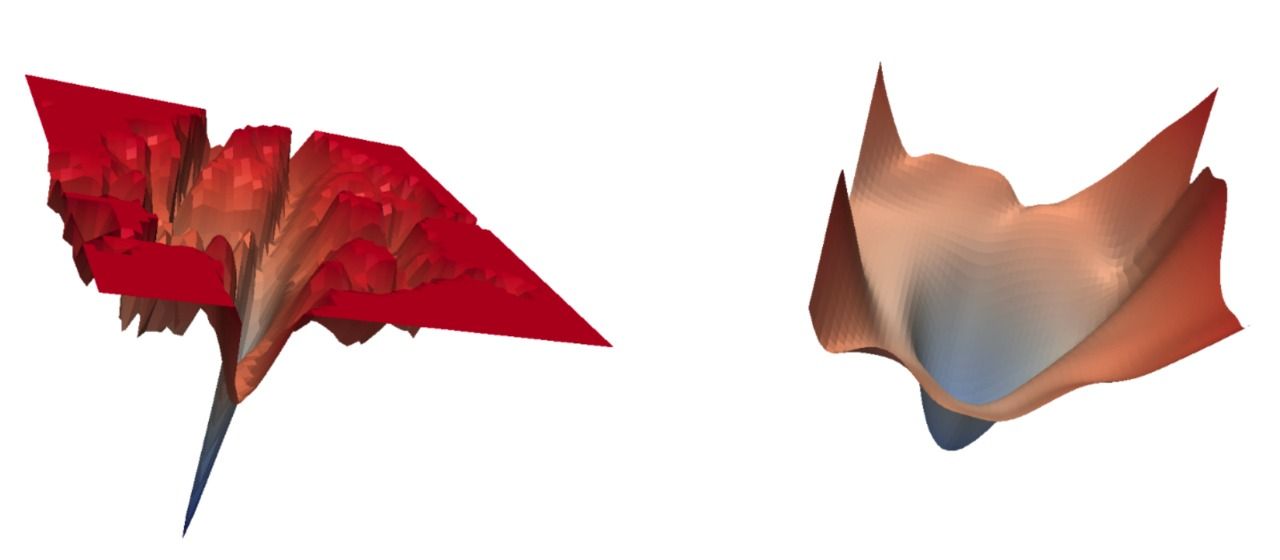
> Image source : [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412) 


# <center> <span style="color:coral">Mathematics behind Sharpness Aware Minimization</span> </center>

For a given loss fuction *L* : *W* x *X* x *Y* $\rightarrow\mathbb{R}_{+}$ , having training loss $L_{S}$,  SAM tries to find parameter **w** in the neighbourhood $\large\rho$ that has low loss as well as low curvature by optimizing the minmax objective which is given by:

$$
\underset{\substack{w}}{min}\; L_{S}^{SAM}(w)+\lambda{||w||_{2}^{2}} \quad\;\;{where}\quad\;\;  L_{S}^{SAM}(w)\;{\underset{\substack{=}}{\Delta}}  \;\underset{\substack{||\epsilon ||_{p}}\le\rho}{max}  L_{S} (w + \epsilon)
$$
> **Note** SAM optimizer has only one `hyperparameter` $\rho$ that is the size of neighbourhood we want to optimize.

For minimization of $L_{S}^{SAM}(w)$ we have to get efficent approximation of $\nabla_{w} L_{S}^{SAM}(w)$ to solve the inner maximization. For this we have to do first order approximation of $ L_{S}(w+\epsilon)$ wrt $\epsilon$ around 0. 

$$
\epsilon^{*}\;{\underset{\substack{=}}{\Delta}}\;
\underset{\substack{||\epsilon ||_{p}}\le\rho}{arg max}L_{S}(w+\epsilon) \;\;\approx\;\; \underset{\substack{||\epsilon ||_{p}}\le\rho}{arg max}L_{S}(w)+\epsilon^{T}\nabla_{w}{L_{S}}(w)\;\;{=}\;\;\underset{\substack{||\epsilon ||_{p}}\le\rho}{arg max}\;\epsilon^{T}\nabla_{w}{L_{S}}(w)
$$

Here ${\epsilon^{*}}$ is nothing but argmax of dot product of two vectors $\epsilon^{T}$ and $\nabla_{w}{L_{S}}(w)$.
The solution to this is dual norm which gives us,

$$
\hat{\epsilon}(w) = \rho{sign} (\nabla_{w}{L_{S}}(w)) \frac{|\nabla_{w}{L_{S}}(w)|^{q-1}}  {( ||\nabla_{w}{L_{S}}(w)||_{q}^{q} )^ {\frac{1}{p}}}
$$

Authors have suggested that optimal value of p is 2 so for p=2,

$$
\hat{\epsilon}(w) = \frac{\rho}{||\nabla_{w}{L_{S}}(w)||_{2}^{2} } (\nabla_{w}{L_{S}}(w))
$$

Substituting this value of $\hat{\epsilon}(w)$ in $L_{S}^{SAM}(w)$ we can calculate the efficient approximation of `SAM gradient`  $\nabla_{w} L_{S}^{SAM}(w)$ thus solving the min max objective. The Implementation part of this is fairly simple in tensorflow.

> I will suggest reading the SAM portion and appendix of the [research paper](https://arxiv.org/pdf/2010.01412.pdf) to get clear idea about the maths behind SAM.
<!-- 
$$
\nabla_{w} L_{S}^{SAM}(w) \approx \nabla_{w}{L_{S}}(w+\hat{\epsilon}(w)) = \frac{d(w+\hat{\epsilon}(w))}{d(w)}\nabla_{w}{L_{S}}|_{w+\hat{\epsilon}(w)}
$$ -->

#### **`Note`**: If you are struggling with mathematics part please move to Algorithm and working section where you can create an intuition of the whole SAM algorithm :)

# <center> <span style="color:coral">Algorithm and working</span> </center>

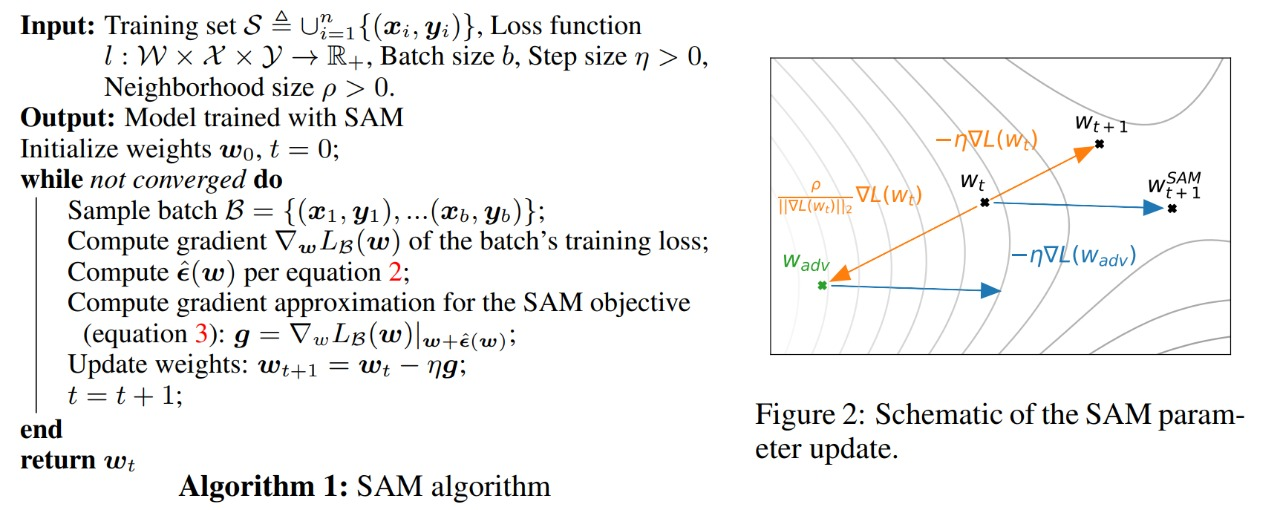
> Image source : [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412) 


The SAM algorithm can be divided into two steps:

1. Calculate adversial point $\large{w}_{adv}$ *having highest* loss in neighbourhood $\rho$ by computing $\large\hat{\epsilon}$, i.e in this step we temporarily move from intial paramter $\large w_{t}$ to the adversial point $\large w_{adv}$ and compute the gradient at $\large w_{adv}$  as shown in lower half of figure 2.

> **Note** if we were using normal gradient descent we would have updated the parameter $\large w_{t}$  on basis gradient at $\large w_{t}$ and learning rate $\eta$ and after the update we would go from $\large w_{t}$ to $\large w_{t+1}$ as compared to two steps required in SAM. 
    
2. From the gradient computed at adversial point $\large w_{adv}$ in previous step we update the intial parameter $\large w_{t}$ by learning rate $\eta$ in direction of  gradient at $\large w_{adv}$ so after the update we reach at point $\large w_{t+1}^{SAM}$ thus performing Sharpness Aware update.

# <center> <span style="color:coral">Implementation</span> </center>

* For implementing `SAM optimizer` I will use Model [subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) to `override` ***the train_step*** method of model with custom ***train_step_sam*** so this can be implemented when we call fit on our model.

> **Note:** To learn more about customizing train_step try reading this [keras documentation](https://keras.io/guides/customizing_what_happens_in_fit/#a-first-simple-example)

* SAM has only one hyperparameter $\large\rho$, as mentioned earlier it defines the neighborhood size, where we do min max operation.

* Authors have found that $\large\rho$ = 0.05 gives good result on wide range of datasets, for current implementation we will use the same value but you can tune it as per your requirements.

* I will be using [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function) model by adding a Global Average pooling layer and a new output layer. 
<!-- For a given batch of data having parameter $w_{t}$ SAM finds an point $w_{adv}$ having high loss and then calculate the gradient at that point and then update the orignal paramter based on the gradient at $w_{adv}$. -->


In [4]:
# creating a custom train_step to override the train_step method of sub_classing model
def train_step_sam(self, data, rho=0.05):
    """
    Overrides the train_step method of Model
    
    Args:
        data : Data on which model is to be trained
        rho  : Hyperparameter Rho indicating the size of neighborhood
    """
    
    sample_weight = None
    x, y = data

    # Opening Gradient Tape scope to record operations during 1st forward pass
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)
        # Calculating loss to calculate gradients
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)

    
    trainable_vars = self.trainable_variables
    # Calculating gradients with respect trainable variable
    gradients = tape.gradient(loss, trainable_vars)

    """
    This is the first step which involves calculating the point w_adv with highest loss and virtually moving to that point so that we can get gradient at that point. 
    """
    eps_w_ls = [] # list to store the updates done to trainable variables in first step
    
    #computing the norm of gradients which is required for computing eps_w
    grad_norm = tf.linalg.global_norm(gradients)
    
    # Iterating over trainable_vars
    for i in range(len(trainable_vars)):
        # we will calculate eps_w to find w_adv point having highest loss in rho neighborhood
        eps_w = tf.math.multiply(gradients[i], rho / grad_norm )
        # temporarily moving to w_adv point
        trainable_vars[i].assign_add(eps_w)
        # storing updates done in eps_w_ls list 
        eps_w_ls.append(eps_w)

    # Opening Gradient Tape scope to record operations during 2nd forward pass
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) 
        # Calculating loss to calculate gradient at w_adv point
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)
        
    trainable_vars = self.trainable_variables
    #computing gradient at w_adv which is our objective in this first step
    gradients = tape.gradient(loss, trainable_vars)

    """
    This is the second step in SAM where we will do actual update at the initial point from the gradient calculated at adversial point w_adv 
    """
    
    for i in range(len(trainable_vars)):
        # Going back to orignal parameters
        trainable_vars[i].assign_sub(eps_w_ls[i])
    
    # Updating parameters with gradients computed at w_adv
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Updating the metrics.
    self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

    # returns a dictionary mapping metric names (including the loss) to their current value.
    return {m.name: m.result() for m in self.metrics}

In [5]:
# using ResNet50 as the model for testing SAM 
base_model=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=None,input_shape=(32,32,3),classes=10)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
# using model subclassing so we can override the train_step
class MyModel(Model):

    # defining the model, for this notebook I will be using ResNet50 model and changing the output layer
    def __init__(self,num_classes=10):
        super(MyModel, self).__init__(name='ResNet50')
        self.base=base_model
        self.gpool=GlobalAveragePooling2D()
        self.dense=Dense(num_classes,activation='softmax')
     
    def call(self, x):
        x = self.base(x) # calling the resnet50 model
        x=self.gpool(x) # Performing global average pooling
        x=self.dense(x) # adding output layer
        return x
    
    # overriding the train_step method  with our custom train_step_sam created in earlier cell
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05) # using rho as 0.05 you can tune this hyperparameter


In [7]:
# Instantiating our ResNet Model
model = MyModel()
model.build((None, 32,32, 3))

# compiling our model with SGD as base optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Training our Model for 60 epochs
history=model.fit(train_data,
          epochs=60,
          validation_data=test_data)

2022-09-26 08:52:57.624240: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.
2022-09-26 08:52:58.506241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-26 08:52:58.563305: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 1/60


2022-09-26 08:53:09.775157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 58s 107ms/step - loss: 2.6579 - accuracy: 0.1557 - val_loss: 4.1331 - val_accuracy: 0.1895


2022-09-26 08:53:57.990562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 2/60
391/391 [==============================] - 41s 105ms/step - loss: 1.8993 - accuracy: 0.3017 - val_loss: 1.5926 - val_accuracy: 0.4824
Epoch 3/60
391/391 [==============================] - 41s 104ms/step - loss: 1.6421 - accuracy: 0.4005 - val_loss: 1.3836 - val_accuracy: 0.5446
Epoch 4/60
391/391 [==============================] - 41s 104ms/step - loss: 1.4773 - accuracy: 0.4618 - val_loss: 1.2592 - val_accuracy: 0.5833
Epoch 5/60
391/391 [==============================] - 41s 104ms/step - loss: 1.3550 - accuracy: 0.5020 - val_loss: 1.2176 - val_accuracy: 0.6083
Epoch 6/60
391/391 [==============================] - 41s 104ms/step - loss: 1.2687 - accuracy: 0.5342 - val_loss: 1.1471 - val_accuracy: 0.6277
Epoch 7/60
391/391 [==============================] - 41s 104ms/step - loss: 1.1923 - accuracy: 0.5623 - val_loss: 1.0153 - val_accuracy: 0.6547
Epoch 8/60
391/391 [==============================] - 41s 104ms/step - loss: 1.1357 - accuracy: 0.5844 - val_loss: 1.0031 - val_ac

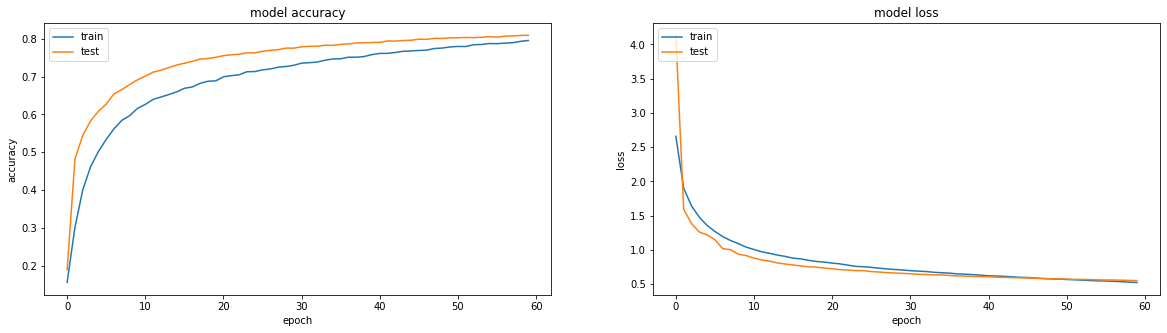

In [8]:
# Plotting loss and accuracy curves
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion

* To conclude in this notebook I have explained SAM algorithm and implemented it using tensorflow to train a ResNet50 model on cifar10 dataset.

* Using SAM gives `State-of-the-Art` results on some well known datasets such as [Image Classification on Cifar-100](https://paperswithcode.com/sota/image-classification-on-cifar-100) and [Fine-Grained Image Classification on Food-101](https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101).

* In the paper [WHEN VISION TRANSFORMERS OUTPERFORM
RESNETS WITHOUT PRE-TRAINING OR STRONG DATA
AUGMENTATIONS](https://arxiv.org/pdf/2106.01548.pdf) authors have found that using SAM with vision transformer(ViT) model converge to a flatter minima improving generalization regarding accuracy and robustness.

* Earlier SAM was majorly utilized on computer vision tasks but lately authors have also explained implementation of SAM on NLP task in research paper [Sharpness-Aware Minimization Improves Language Model
Generalization](https://arxiv.org/pdf/2110.08529.pdf)

# References
[https://arxiv.org/pdf/2010.01412.pdf](https://arxiv.org/pdf/2010.01412.pdf)

[https://github.com/google-research/sam](https://github.com/google-research/sam)

[https://arxiv.org/pdf/1609.04836.pdf](https://arxiv.org/pdf/1609.04836.pdf)

[https://keras.io/guides/customizing_what_happens_in_fit/](https://keras.io/guides/customizing_what_happens_in_fit/)

[https://github.com/davda54/sam](https://github.com/davda54/sam)

[https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class)

[https://arxiv.org/pdf/2110.08529.pdf](https://arxiv.org/pdf/2110.08529.pdf)

[https://www.inference.vc/sharp-vs-flat-minima-are-still-a-mystery-to-me/](https://www.inference.vc/sharp-vs-flat-minima-are-still-a-mystery-to-me/)

[https://en.wikipedia.org/wiki/Dual_norm](https://en.wikipedia.org/wiki/Dual_norm)

# Citation
```bibtex
@ARTICLE{2020arXiv201001412F,
       author = {{Foret}, Pierre and {Kleiner}, Ariel and {Mobahi}, Hossein and {Neyshabur}, Behnam},
        title = "{Sharpness-Aware Minimization for Efficiently Improving Generalization}",
         year = 2020,
          eid = {arXiv:2010.01412},
       eprint = {2010.01412},
}
```